## **Momento de Retroalimentación** *~ Módulo 2 ~*

Implementación de un modelo de deep learning

Julio G. Arriaga Blumenkron


Alfredo Azamar López -- *A01798100*

----------

**Introducción**

La detección temprana de enfermedades en cultivos es crucial para la agricultura, ya que permite aplicar medidas de control y minimizar pérdidas. Este proyecto está enfocado en la clasificación de imágenes para detectar y diferenciar entre estados de salud y tipos de enfermedades en 4 cultivos:
* "Anacardo" (también conocido como nuez de la india)
* "Yuca"
* "Maíz"
* "Tomate"



Con el objetivo de ayudar a los agricultores a tomar decisiones informadas a la hora de detectar y controlar problemas en sus cultivos. La automatización de este proceso mediante redes neuronales puede optimizar el monitoreo y tratamiento de cultivos, aumentando la eficiencia y reduciendo pérdidas.

-----

**Datos**

*Descripción*

El dataset "CCMT" se descargó de la plataforma *Kaggle*, este contiene 24,881 imágenes a color divididas en 4 categorías de cultivo.

Cada categoría incluye imágenes de plantas en estado saludable y afectadas por enfermedades específicas. Las imágenes tienen resoluciones variadas y han sido obtenidas de granjas locales en Ghana.

*Preprocesamiento*

Cada imagen está clasificada en carpetas según el tipo de cultivo y condición (saludable o enfermedad). Dada la gran variedad de resoluciones, las imágenes fueron redimensionadas a un tamaño de entrada uniforme de 224x224 píxeles para su procesamiento por el modelo.


*Separación*

El dataset está dividido en tres subconjuntos: "train", "test" y "valid", con el objetivo de entrenar, validar y evaluar el modelo. La división original se mantuvo para asegurar una evaluación consistente.

------

***Implementación***

In [1]:
# Importación de librerías
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomHeight, RandomWidth, Input, Rescaling, Resizing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

*Obteniendo del dataset proveniente de Kaggle*





In [ ]:
!pip install -q kaggle

In [ ]:
# Subir la llave (API) de Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfredoazamar","key":"85fc305c57cf0edea18fae9807072b70"}'}

In [ ]:
# Configuración de la Kaggle library
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargando el dataset
!kaggle datasets download -d armaanoajay/ccmt-crop-pest-and-disease-detection

Dataset URL: https://www.kaggle.com/datasets/armaanoajay/ccmt-crop-pest-and-disease-detection
License(s): unknown
100% 5.00G/5.00G [04:13<00:00, 17.5MB/s]
100% 5.00G/5.00G [04:13<00:00, 21.2MB/s]


In [ ]:
# Descomprimiendo
import zipfile
with zipfile.ZipFile("ccmt-crop-pest-and-disease-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [2]:
# Verificación de la carga del dataset

# Ruta a la carpeta "train" dentro del dataset
train_data_dir = os.path.join("dataset", "split-new")

# Verificar si la carpeta existe
if os.path.exists(train_data_dir):
  print(f"La carpeta con los datos de entrenamiento está en: {train_data_dir}")

  # Puedes listar los archivos y subcarpetas dentro de la carpeta "train" si lo deseas
  for item in os.listdir(train_data_dir):
    print(item)
else:
  print("No se encontró la carpeta 'train'. Asegúrate de que la ruta sea correcta.")



La carpeta con los datos de entrenamiento está en: dataset/split-new
valid
.DS_Store
test
train


------------

*Preprocesamiento el dataset*

In [3]:
# Seccionamiento de los datos

base_dir = 'dataset/split-new'
train_data_dir = os.path.join(base_dir, 'train')
validation_data_dir = os.path.join(base_dir, 'valid')
test_data_dir = os.path.join(base_dir, 'test')


# Verificamos que las rutas sean correctas
for directory in [train_data_dir, validation_data_dir, test_data_dir]:
    if os.path.exists(directory):
        print(f"La carpeta {directory} está lista.")
    else:
        print(f"Error: No se encontró la carpeta {directory}.")

La carpeta dataset/split-new/train está lista.
La carpeta dataset/split-new/valid está lista.
La carpeta dataset/split-new/test está lista.


In [4]:
img_height, img_width = 224, 224
batch_size = 32

# Cargar datasets con `image_dataset_from_directory`
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # Mantener orden para evaluaciones
)

class_labels = train_dataset.class_names

AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


# # Generador para validación y prueba (sin aumento de datos)
# validation_datagen = ImageDataGenerator(rescale=1./255)

# # Crear generadores para cargar las imágenes desde las carpetas
# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# validation_generator = validation_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical'
# )

# test_generator = validation_datagen.flow_from_directory(
#     test_data_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode='categorical',
#     shuffle=False  # Para evaluaciones o predicciones ordenadas
# )

Found 15062 files belonging to 22 classes.
Found 5012 files belonging to 22 classes.
Found 5052 files belonging to 22 classes.


-----------

**Desarrollo del modelo**

*Arquitectura*

La primera versión del modelo está formada por una **capa de entrada**, que contiene una capa "Conv2D" que aplica 32 filtros de tamaño (3, 3) a la imagen de entrada, seguida de una función de activación "ReLU" para introducir no linealidad.

Despúes se tienen las **capas intermedias** con la siguiente configuración: incluyen una capa "Conv2D" que aumenta el número de filtros (64, 128 y 256) manteniendo el tamaño del filtro en (3, 3) y aplica la activación "ReLU". Cada capa convolucional es seguida por una capa "MaxPooling2D" que reduce la resolución de las características detectadas y una capa "BatchNormalization" que estabiliza el aprendizaje al normalizar la activación de cada minibatch.

Al final la **capa de salida**, aplana la salida de las capas convolucionales mediante una función "Flatten", se usa una capa "Dense" con 256 unidades y activación ReLU para realizar un análisis más profundo de las características extraídas. Después se incorpora "Dropout" con un valor de 0.5 (para evitar el sobreajuste). La capa de salida es una capa "Dense" con 22 neuronas y activación softmax, lo que permite al modelo generar una probabilidad para cada una de las 22 clases.

In [5]:
# Creación del primer modelo

# Transformaciones para el aumento de datos
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.1),
    RandomHeight(0.1),
    RandomWidth(0.1),
    Resizing(img_height, img_width),
])

model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(22, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,171,798 (42.62 MB)

 Trainable params: 11,171,798 (42.62 MB)

 Non-trainable params: 0 (0.00 B)

*Entrenamiento*

Para la compilación del modelo se usa el optimizador "Adam", que es eficiente y funciona bien en tareas de clasificación de imágenes y la función de pérdida fue "categorical_crossentropy" (adecuada para tareas de clasificación multiclase).

Para el entrenamiento, se utilizó una estrategia de "EarlyStopping" con un monitoreo de la pérdida en el conjunto de validación (val_loss) y una paciencia de 3 épocas. Esto ayuda a prevenir el sobreajuste, ya que detiene el entrenamiento cuando el modelo deja de mejorar en el conjunto de validación y restaura los mejores pesos.

El modelo fue entrenado durante un máximo de 20 épocas, utilizando "train_dataset" y "validation_generato" como generadores de datos

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 205s 433ms/step - accuracy: 0.1613 - loss: 2.8140 - val_accuracy: 0.2923 - val_loss: 2.2777
Epoch 2/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 204s 434ms/step - accuracy: 0.2704 - loss: 2.3550 - val_accuracy: 0.3579 - val_loss: 2.1023
Epoch 3/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 205s 436ms/step - accuracy: 0.3239 - loss: 2.1354 - val_accuracy: 0.4387 - val_loss: 1.7560
Epoch 4/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 206s 437ms/step - accuracy: 0.3568 - loss: 2.0131 - val_accuracy: 0.4377 - val_loss: 1.7248
Epoch 5/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 205s 436ms/step - accuracy: 0.3812 - loss: 1.9387 - val_accuracy: 0.4613 - val_loss: 1.6688
Epoch 6/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 206s 437ms/step - accuracy: 0.4084 - loss: 1.8470 - val_accuracy: 0.4800 - val_loss: 1.6149
Epoch 7/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 206s 437ms/step - accuracy: 0.4144 - loss: 1.8035 - val_accuracy: 0.5192 - val_loss: 1.5053
Epoch 8/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 207s 439ms/step - accuracy: 

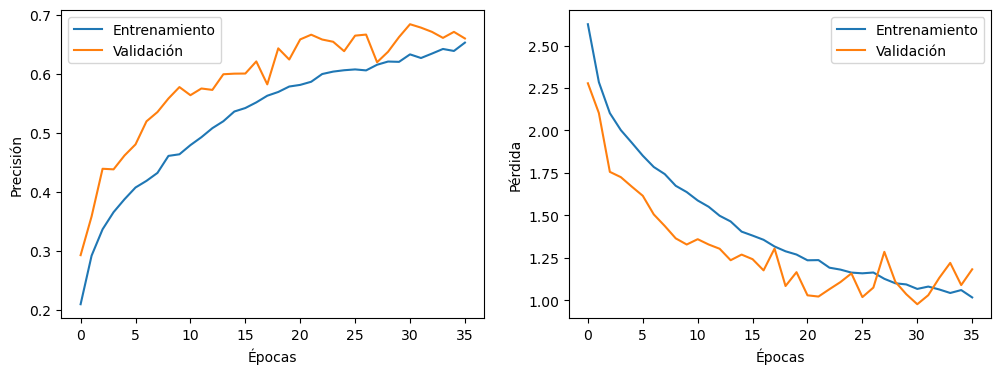

In [7]:
# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


*Evaluación*

Al final del entrenamiento, el modelo logró una precisión de validación del 35%. Esto sugiere que el modelo no logra generalizar suficientemente bien sobre los datos de validación, posiblemente debido a que la arquitectura puede ser demasiado compleja para el dataset, y el modelo no capta patrones relevantes.

In [8]:
# Evaluación en el conjunto de validación
loss, accuracy = model.evaluate(validation_dataset)
print(f"Precisión en validación: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.6974 - loss: 0.9471
Precisión en validación: 0.68


In [ ]:
# Obtener las predicciones en el conjunto de prueba
predictions = model.predict(test_dataset)

# Convertir las predicciones a etiquetas
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del generador de prueba
true_classes = np.concatenate([y.numpy() for _, y in test_dataset]) # Removed np.argmax and axis=1

# Mostrar algunas métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Precisión en test:", accuracy_score(true_classes, predicted_classes))
print("\nReporte de clasificación:\n", classification_report(true_classes, predicted_classes, target_names=class_labels)) # Now use class_labels!

158/158 ━━━━━━━━━━━━━━━━━━━━ 19s 119ms/step
Precisión en test: 0.6730007917656373

Reporte de clasificación:
                            precision    recall  f1-score   support

       anthracnose-cashew       0.76      0.67      0.71       347
 bacterial blight-cassava       0.60      0.74      0.66       524
       brown spot-cassava       0.64      0.79      0.71       297
    cashew-mosaic-cassava       0.77      0.73      0.75       241
      fall armyworm-maize       0.47      0.16      0.24        57
         grasshoper-maize       0.58      0.67      0.62       136
       green mite-cassava       0.62      0.77      0.69       203
           gumosis-cashew       0.85      0.80      0.82        79
           healthy-cashew       0.85      0.71      0.78       275
          healthy-cassava       0.87      0.81      0.84       240
            healthy-maize       0.55      0.15      0.23        41
           healthy-tomato       0.80      0.38      0.51        95
        leaf beetl

----

**Ajuste del modelo**

Para la mejora del modelo se tiene una red neuronal convolucional más sencilla, la arquitectura es más compacta y se conforma de un número menor de capas, lo cual puede favorecer su rendimiento.

*Arquitectura*

Está formada por una **capa de entrada**, que contiene una capa "Conv2D" que aplica 32 filtros de tamaño (3, 3) a la imagen de entrada, seguida de una función de activación "ReLU" para introducir no linealidad.

Despúes se tienen las **capas intermedias** (2 bloques) con la siguiente configuración: incluyen una capa "Conv2D" que aumenta el número de filtros (64 y 128) manteniendo el tamaño del filtro en (3, 3) y aplica la activación "ReLU". Cada capa convolucional es seguida por una capa "MaxPooling2D" que reduce la resolución de las características detectadas.

Al final la **capa de salida**, aplana la salida de las capas convolucionales mediante una función "Flatten", se usa una capa "Dense" con 128 unidades y activación ReLU para realizar un análisis más profundo de las características extraídas. Después se incorpora "Dropout" con un valor de 0.5 (para evitar el sobreajuste). La capa de salida es una capa "Dense" con 22 neuronas y activación softmax, lo que permite al modelo generar una probabilidad para cada una de las 22 clases.

In [14]:
## INTENTO 2 PARA EL 2° MODELO

data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.3),
    RandomZoom(0.4),
    RandomHeight(0.3),
    RandomWidth(0.3),
    Resizing(img_height, img_width),
    tf.keras.layers.RandomContrast(0.4),
    tf.keras.layers.RandomBrightness(0.4)
])

model2 = Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    Rescaling(1./255),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(22, activation='softmax')  # 22 clases en el dataset
])

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,209,942 (12.24 MB)

 Trainable params: 3,209,942 (12.24 MB)

 Non-trainable params: 0 (0.00 B)

*Entrenamiento*

Para la compilación del modelo se usa el optimizador "Adam", que es eficiente y funciona bien en tareas de clasificación de imágenes y la función de pérdida fue "categorical_crossentropy" (adecuada para tareas de clasificación multiclase).

Para evitar el sobreajuste, se ha implementado "EarlyStopping", que monitoriza la pérdida en el conjunto de validación ("val_loss") con una paciencia de 3 épocas y restaura los mejores pesos obtenidos. El entrenamiento se realizó durante un máximo de 20 épocas, utilizando generadores de datos "train_dataset" y "validation_dataset" para manejar eficientemente grandes lotes de imágenes.

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history2 = model2.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping]
)

Epoch 1/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 273s 577ms/step - accuracy: 0.1021 - loss: 2.9875 - val_accuracy: 0.1840 - val_loss: 2.7091
Epoch 2/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 271s 575ms/step - accuracy: 0.1581 - loss: 2.7467 - val_accuracy: 0.2332 - val_loss: 2.4211
Epoch 3/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 273s 580ms/step - accuracy: 0.2068 - loss: 2.5341 - val_accuracy: 0.3113 - val_loss: 2.1487
Epoch 4/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 273s 580ms/step - accuracy: 0.2703 - loss: 2.3053 - val_accuracy: 0.3829 - val_loss: 1.9149
Epoch 5/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 272s 578ms/step - accuracy: 0.3348 - loss: 2.0788 - val_accuracy: 0.4178 - val_loss: 1.7576
Epoch 6/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 273s 579ms/step - accuracy: 0.3708 - loss: 1.9408 - val_accuracy: 0.4639 - val_loss: 1.6131
Epoch 7/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 281s 596ms/step - accuracy: 0.4044 - loss: 1.8162 - val_accuracy: 0.5008 - val_loss: 1.4972
Epoch 8/100
471/471 ━━━━━━━━━━━━━━━━━━━━ 279s 593ms/step - accuracy: 

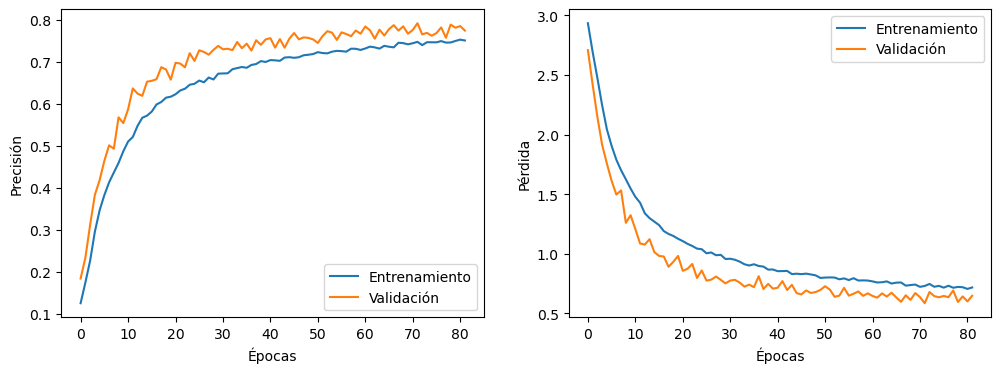

In [16]:
# Gráfica de precisión y pérdida
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Entrenamiento')
plt.plot(history2.history['val_accuracy'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Entrenamiento')
plt.plot(history2.history['val_loss'], label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

plt.show()


*Evaluación*

El modelo alcanzó una precisión de validación del 63%, una mejora notable frente al primer modelo (38%). Esto sugiere que el modelo es capaz de generalizar mejor sobre el conjunto de validación y de captar patrones relevantes en el dataset, posiblemente debido a que su arquitectura más simple podría reducir el riesgo de sobreajuste al centrarse en las características esenciales. Al igual que la cantidad de capas y filtros, en la segunda implementación se redujó el número y se permitió un entrenamiento más eficiente, lo cual podría ser más adecuado para el conjunto de datos.

In [17]:
# Evaluación en el conjunto de validación
loss, accuracy = model2.evaluate(validation_dataset)
print(f"Precisión en validación: {accuracy:.2f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 23s 145ms/step - accuracy: 0.7980 - loss: 0.5606
Precisión en validación: 0.79


In [22]:
# Obtener las predicciones en el conjunto de prueba
predictions = model2.predict(test_dataset)

# Convertir las predicciones a etiquetas
predicted_classes = np.argmax(predictions, axis=1)

# Obtener las etiquetas reales del generador de prueba
true_classes = np.concatenate([y.numpy() for _, y in test_dataset]) # Removed np.argmax and axis=1

# Mostrar algunas métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print("Precisión en test:", accuracy_score(true_classes, predicted_classes))
print("\nReporte de clasificación:\n", classification_report(true_classes, predicted_classes, target_names=class_labels)) # Now use class_labels!


158/158 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step
Precisión en test: 0.7779097387173397

Reporte de clasificación:
                            precision    recall  f1-score   support

       anthracnose-cashew       0.78      0.84      0.80       347
 bacterial blight-cassava       0.79      0.78      0.79       524
       brown spot-cassava       0.76      0.88      0.81       297
    cashew-mosaic-cassava       0.97      0.85      0.91       241
      fall armyworm-maize       0.62      0.37      0.46        57
         grasshoper-maize       0.86      0.69      0.77       136
       green mite-cassava       0.83      0.77      0.80       203
           gumosis-cashew       0.90      0.92      0.91        79
           healthy-cashew       0.89      0.85      0.87       275
          healthy-cassava       0.92      0.90      0.91       240
            healthy-maize       0.91      0.73      0.81        41
           healthy-tomato       0.89      0.83      0.86        95
        leaf beetl

------

**Resultados**

Para evaluar el rendimiento final del modelo, se utilizó el conjunto de prueba. Los resultados mostraron una precisión promedio del 63%, con la capacidad del modelo para clasificar correctamente varias enfermedades en los cultivos. Las predicciones indican que el modelo puede identificar con éxito la mayoría de las enfermedades, aunque ciertas clases siguen presentando errores, probablemente debido a similitudes visuales entre enfermedades en distintos cultivos.

**Conclusiones**

El desarrollo de este modelo de clasificación de imágenes para la detección de enfermedades en cultivos ha mostrado resultados prometedores, alcanzando un 63% de precisión en la versión ajustada. Sin embargo, destaca áreas de mejora. Los resultados podrían beneficiarse de un modelo más robusto, como una arquitectura preentrenada para extraer características de manera más eficaz. Además, ajustar la cantidad de datos por clase podría ayudar a mejorar el rendimiento en clases con menor precisión.

----

**Aplicación**

In [21]:
from tensorflow.keras.preprocessing import image

# Ruta de una imagen individual para prueba
img_path = '/Users/alfyazamar/Downloads/cassava.jpg' # Cambiar por la ruta de tu imagen

# Cargar y preprocesar la imagen
img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalizar como en el entrenamiento

# Hacer la predicción
prediction = model2.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

# Mostrar resultado
print("Predicción:", class_labels[predicted_class])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicción: anthracnose-cashew


----

*Guardando el modelo entrenado*

In [ ]:
#COLAB
model2.save('trained_model.keras')
!zip -r trained_model.zip trained_model.keras

files.download('trained_model.zip')

In [ ]:
#LOCAL
from IPython.display import FileLink

model2.save('trained_model.keras')
!zip -r trained_model.zip trained_model.keras

FileLink('trained_model.zip')

updating: trained_model.keras (deflated 20%)


/Users/alfyazamar/Downloads/trained_model.zip